# parPE example: steadystate model - hierarchical optimization

This notebooks demonstrates the use of parPE for parameter estimation using a recently developed hierarchical optimization approach (https://academic.oup.com/bioinformatics/advance-article/doi/10.1093/bioinformatics/btz581/5538985).

The model and data used in this notebook are described in more detail in `parpeExampleSteadystateBasic.ipynb`.


## Prerequisites

The prerequisites mentioned in `parpeExampleSteadystateBasic.ipynb` also apply to this notebook.

In [1]:
import amici
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py
from importlib import reload
import parpe

# set paths
parpe_source_root = os.path.abspath('../../../')
parpe_build_root = os.path.join(parpe_source_root, 'build')

model_source_dir = f'{parpe_build_root}/examples/parpeamici/steadystate/steadystate_scaled-prefix/src/steadystate_scaled/model_steadystate_scaled'
example_binary_dir = f'{parpe_build_root}/examples/parpeamici/steadystate/'
example_data_dir = f'{parpe_build_root}/examples/parpeamici/steadystate/steadystate_scaled-prefix/src/steadystate_scaled'
optimization_options_py = f'{parpe_source_root}/misc/optimizationOptions.py'

In [2]:
# rebuild example
!cd {parpe_build_root} && make

-- Found Git: /usr/bin/git (found version "2.25.1") 
-- Building version parPE-v0.4.3-41-g696ed
[  0%] Built target get_version
[ 10%] Built target parpecommon
Scanning dependencies of target parpeoptimization
[ 11%] Building CXX object src/parpeoptimization/CMakeFiles/parpeoptimization.dir/optimizationResultWriter.cpp.o
[ 12%] Linking CXX static library libparpeoptimization-dbg.a
[ 21%] Built target parpeoptimization
[ 25%] Built target parpeloadbalancer
Scanning dependencies of target parpeamici
[ 26%] Building CXX object src/parpeamici/CMakeFiles/parpeamici.dir/optimizationApplication.cpp.o
[ 27%] Linking CXX static library libparpeamici-dbg.a
[ 37%] Built target parpeamici
[ 39%] Built target parpe
[ 45%] Built target unittests_common
[ 50%] Built target unittests_loadbalancer
[ 51%] Linking CXX executable unittests_optimization
[ 58%] Built target unittests_optimization
Setting up virtual environment...
[ 58%] Built target setup_venv
[ 59%] Creating test data using hierarchicalOpt

In [3]:
# run make test to generated all output files required below
#!cd {parpe_build_root} && make test

## Hierarchical optimization

Depending on the type of training data, the parameter estimation may contain a large number of output or nuisance parameters necessary to model the measurement process and transform model states to the actually measured quantity. These parameters are required for model parameterization, but don't affect the model states. This could for example be scaling parameters, in the case of relative measurements.

We recently developed an hierarchical optimization approach (https://www.biorxiv.org/content/early/2018/01/15/247924), that allows to analytically compute scaling, offset and sigma parameters. For large models, this can greatly improve optimizer convergence, and therefore, computation time.

In this hierarchical approach, the optimization problems is split into *dynamic parameters*, influencing the state of the system, and *static* or *output parameters*, which do not influence the state of system, but only its outputs. The numeric optimization algorithm is used to optimize the dynamic parameters only. Given these dynamic parameters, we can determine locally optimal values for some output parameters (in this example: all) analytically during each iteration. More detailed descriptions and the theoretical basis are provided in https://academic.oup.com/bioinformatics/article/34/24/4266/5053308, https://www.biorxiv.org/content/early/2018/01/15/247924, and the respective supplementary information.


### Optimize

In [4]:
hdf5_input_file_hierarchical = f'{example_data_dir}/example_data.h5'
hdf5_pe_output_file_hierarchical = 'deletemehierarchical/_rank00000.h5'

# Enabling hierarchical optimization in parPE is as easy as this:
!{optimization_options_py} {hdf5_input_file_hierarchical} -s hierarchicalOptimization 1

# Set some additional options, independently of hierarchical optimization
!{optimization_options_py} {hdf5_input_file_hierarchical} -s numStarts 1
!{optimization_options_py} {hdf5_input_file_hierarchical} -s ipopt/max_iter 20
!{optimization_options_py} {hdf5_input_file_hierarchical} -s ipopt/acceptable_obj_change_tol 1e-5
!{optimization_options_py} {hdf5_input_file_hierarchical} -s ipopt/acceptable_tol 1e-5
!{optimization_options_py} {hdf5_input_file_hierarchical} -s retryOptimization 0

# Print current settings
!{optimization_options_py} {hdf5_input_file_hierarchical}


                hierarchicalOptimization            1
                               numStarts            1
                               optimizer            0
                       retryOptimization            0
                ceres/max_num_iterations          100
                         fmincon/GradObj        b'on'
                     fmincon/MaxFunEvals   10000000.0
                         fmincon/MaxIter          100
                          fmincon/TolFun            0
                            fmincon/TolX        1e-08
                       fmincon/algorithm b'interior-point'
                         fmincon/display      b'iter'
                   ipopt/acceptable_iter            1
         ipopt/acceptable_obj_change_tol        1e-05
                    ipopt/acceptable_tol        1e-05
             ipopt/hessian_approximation b'limited-memory'
        ipopt/limited_memory_update_type      b'bfgs'
                          ipopt/max_iter           20
                  

In [5]:
# Before starting the optimization, we can shortly compare the objective function gradients computed by AMICI/parPE with finite differences:
!PARPE_NO_DEBUG=1 {example_binary_dir}/example_steadystate_multi -t gradient_check -o deletemegc/ {hdf5_input_file_hierarchical}

[2020-06-24 17:51:09] [INF] [-1:140661450438592/]     0 g:  3.70264e+06  fd_c:  3.71926e+06  Δ/ff: -1.316027e-05  f:  1.26298e+09
[2020-06-24 17:51:09] [INF] [-1:140661450438592/]     1 g: -6.39635e+06  fd_c: -6.37737e+06  Δ/ff: -1.502652e-05  f:  1.26298e+09
[2020-06-24 17:51:09] [INF] [-1:140661450438592/]     2 g:      -646595  fd_c:      -674557  Δ/ff: 2.213978e-05  f:  1.26298e+09
[2020-06-24 17:51:09] [INF] [-1:140661450438592/]     3 g:  5.96119e+06  fd_c:  5.96607e+06  Δ/ff: -3.868144e-06  f:  1.26298e+09
[2020-06-24 17:51:09] [INF] [-1:140661450438592/]     4 g:  5.80955e+09  fd_c:  5.80954e+09  Δ/ff: 1.416672e-05  f:  1.26303e+09
[2020-06-24 17:51:09] [INF] [-1:140661450438592/] Walltime on master: 0.245290s, CPU time of all processes: 1.148713s


In [6]:
# Run the actual optimization (using MPI with 4 processes, 1 master, 3 workers)
!PARPE_NO_DEBUG=1 mpiexec -n 4 {example_binary_dir}/example_steadystate_multi  -o deletemehierarchical/ {hdf5_input_file_hierarchical} --mpi


[2020-06-24 17:51:10] [INF] [0:139634931677120/dweindl-ThinkPad-L480] Running with 4 MPI processes.
[2020-06-24 17:51:10] [INF] [0:139634931677120/dweindl-ThinkPad-L480] Reading random initial theta 0 from /optimizationOptions/randomStarts

List of user-set options:

                                    Name   Value                used
                         acceptable_iter = 1                     yes
               acceptable_obj_change_tol = 1e-05                 yes
                          acceptable_tol = 1e-05                 yes
                   hessian_approximation = limited-memory        yes
              limited_memory_update_type = bfgs                  yes
                                max_iter = 20                    yes
                             print_level = 5                     yes
                      print_user_options = yes                   yes
                                     tol = 1e-09                 yes
         watchdog_shortened_iter_trigger =

### Analyze Results

array([[-439.90444215],
       [-440.11048578],
       [-441.25031421],
       [-441.7929597 ],
       [-442.64439443],
       [-443.12253462],
       [-444.5376804 ],
       [-446.57693735],
       [-447.1961445 ],
       [-447.22727595],
       [-447.22878988],
       [-447.23182573],
       [-447.23222174],
       [-447.23457001],
       [-447.23480433],
       [-447.23572432],
       [-447.23593991],
       [-447.23597489],
       [-447.23600574],
       [-447.23600689],
       [-447.23605259]])

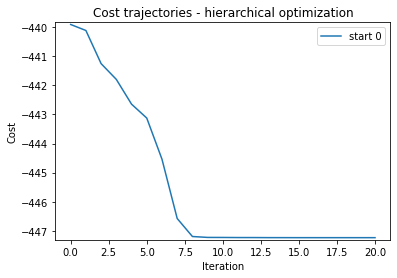

In [7]:
trajectories_hierarchical = parpe.getCostTrajectories(hdf5_pe_output_file_hierarchical)
ax = parpe.plotting.plotCostTrajectory(trajectories_hierarchical, scaleToIteration=0, log=False);
ax.set_title('Cost trajectories - hierarchical optimization')
trajectories_hierarchical

In [8]:
num_starts = trajectories_hierarchical.shape[1]
for start_idx in range(num_starts):
    parpe.compare_optimization_results_to_true_parameters(hdf5_pe_output_file_hierarchical, start_idx=start_idx)

#  __Exp____ __Act______ __Err______ __RelErr___ __ID_______
0:   1.00000     0.30545    -0.69455    -0.69455 p1
1:   0.50000     0.30115    -0.19885    -0.39771 p2
2:   0.40000     0.16319    -0.23681    -0.59202 p3
3:   2.00000     1.81038    -0.18962    -0.09481 p4
4:   0.10000     0.04623    -0.05377    -0.53775 p5
5:   2.00000     0.16235    -1.83765    -0.91882 scaling_x1_common
6:   3.00000     2.99965    -0.00035    -0.00012 offset_x2_batch_0
7:   0.20000     0.13704    -0.06296    -0.31482 x1withsigma_sigma
8:   4.00000     4.00120     0.00120     0.00030 offset_x2_batch_1

Status: 1
Cost: -447.236053 (expected: -0.000000)


In [18]:
!rm -f simh.h5
!{example_binary_dir}/example_steadystate_multi_simulator {hdf5_pe_output_file_hierarchical} /inputData {hdf5_pe_output_file_hierarchical} /inputData simh.h5 / --at-optimum --nompi --compute-inner

Running --at-optimum for 
	conditions from deletemehierarchical/_rank00000.h5:/inputData and 
	parameters from deletemehierarchical/_rank00000.h5:/inputData
	> simh.h5:/
Running for start 0
Starting simulation. Number of conditions: 4
[2020-06-24 17:53:21] [DBG] [-1:140138827208640/] [] HierarchicalOptimizationWrapper parameters: 9 total, 5 numerical, 1 proportionality, 2 offset, 1 sigma


In [19]:
(measured, simulated, timepoints, llh) = parpe.readSimulationsFromFile('simh.h5')
start_idx = '0'

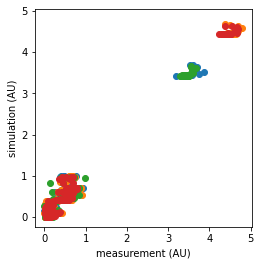

In [20]:
parpe.plotting.plotCorrelation(measured[start_idx], simulated[start_idx]);

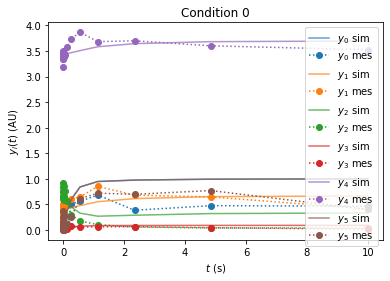

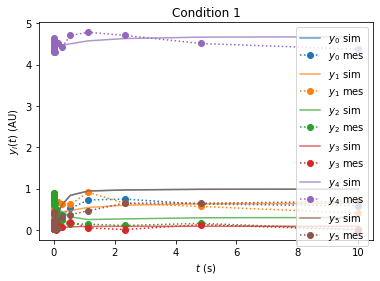

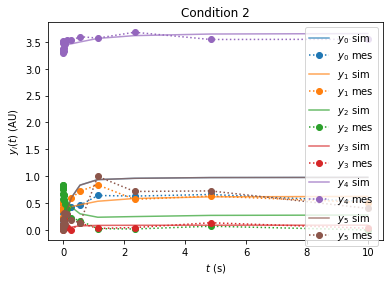

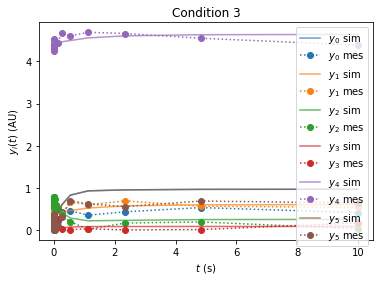

In [22]:
parpe.plotting.plotTrajectoryFits(measured[start_idx], simulated[start_idx], timepoints[start_idx])

## Standard optimization Ipopt

### Set parameter estimation options

Parameter estimation settings specified inside an HDF5 file. Those can be changed from any programming language with HDF5 bindings, with hdfview (https://www.hdfgroup.org/downloads/hdfview/), or with a helper script included in parPE, as demonstrated here:

In [23]:
# enable derivate checker
input_file = f'{example_data_dir}/example_data.h5'

# Perform two optimizer runs from different starting points
!{optimization_options_py} {input_file} -s numStarts 1

# Disable hierarchical optimization
!{optimization_options_py} {input_file} -s hierarchicalOptimization 0

# Print settings
!{optimization_options_py} {input_file}

                hierarchicalOptimization            0
                               numStarts            1
                               optimizer            0
                       retryOptimization            0
                ceres/max_num_iterations          100
                         fmincon/GradObj        b'on'
                     fmincon/MaxFunEvals   10000000.0
                         fmincon/MaxIter          100
                          fmincon/TolFun            0
                            fmincon/TolX        1e-08
                       fmincon/algorithm b'interior-point'
                         fmincon/display      b'iter'
                   ipopt/acceptable_iter            1
         ipopt/acceptable_obj_change_tol        1e-05
                    ipopt/acceptable_tol        1e-05
             ipopt/hessian_approximation b'limited-memory'
        ipopt/limited_memory_update_type      b'bfgs'
                          ipopt/max_iter           20
                  

### Optimize

In [24]:
# !(cd {parpe_build_root} && exec make -j12) # rebuild
!rm -rf deleteme # delete old result files

# optimize (using a single process)
!PARPE_NO_DEBUG=1 {example_binary_dir}/example_steadystate_multi -o deleteme/ {example_data_dir}/example_data.h5


[2020-06-24 17:54:17] [INF] [-1:140203247966144/] Reading random initial theta 0 from /optimizationOptions/randomStarts

List of user-set options:

                                    Name   Value                used
                         acceptable_iter = 1                     yes
               acceptable_obj_change_tol = 1e-05                 yes
                          acceptable_tol = 1e-05                 yes
                   hessian_approximation = limited-memory        yes
              limited_memory_update_type = bfgs                  yes
                                max_iter = 20                    yes
                             print_level = 5                     yes
                      print_user_options = yes                   yes
                                     tol = 1e-09                 yes
         watchdog_shortened_iter_trigger = 0                     yes

******************************************************************************
This program 

### Analyze results

A good start for checking the results is a look at optimizer trajectories. This can be easily done using the *parPE* Python package:

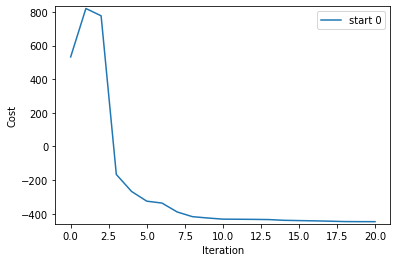

In [25]:
hdf5_pe_output_file_standard = 'deleteme/_rank00000.h5'
trajectories_standard = parpe.getCostTrajectories(hdf5_pe_output_file_standard)
parpe.plotting.plotCostTrajectory(trajectories_standard, log=False);

Since this example uses artificial data based on model simulations with known parameters, we can compare them to the optimization results:

In [26]:
parpe.compare_optimization_results_to_true_parameters(hdf5_pe_output_file_standard, start_idx='0')

#  __Exp____ __Act______ __Err______ __RelErr___ __ID_______
0:   1.00000     0.27496    -0.72504    -0.72504 p1
1:   0.50000     0.30148    -0.19852    -0.39704 p2
2:   0.40000     0.14082    -0.25918    -0.64794 p3
3:   2.00000     1.80128    -0.19872    -0.09936 p4
4:   0.10000     0.04838    -0.05162    -0.51620 p5
5:   2.00000     0.17859    -1.82141    -0.91070 scaling_x1_common
6:   3.00000     3.00079     0.00079     0.00026 offset_x2_batch_0
7:   0.20000     0.13613    -0.06387    -0.31935 x1withsigma_sigma
8:   4.00000     4.00615     0.00615     0.00154 offset_x2_batch_1

Status: 1
Cost: -446.910816 (expected: -0.000000)


In [30]:
# Simulate with optimal parameters, save results
!rm -f sim.h5 # remove files from previous run
!{example_binary_dir}/example_steadystate_multi_simulator {hdf5_pe_output_file_standard} /inputData {hdf5_pe_output_file_standard} /inputData sim.h5 / --at-optimum --nompi --nocompute-inner

Running --at-optimum for 
	conditions from deleteme/_rank00000.h5:/inputData and 
	parameters from deleteme/_rank00000.h5:/inputData
	> sim.h5:/
Running for start 0
Starting simulation. Number of conditions: 4


In [31]:
# Load simulated outputs
(measured, simulated, timepoints, llh) = parpe.readSimulationsFromFile('simh.h5')
start_idx = '0'

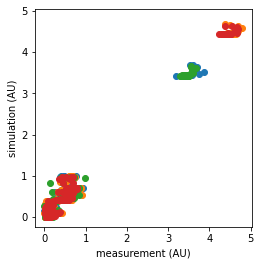

In [32]:
# Plot correlation of measurements (training data) and model simulation with optimized parameters
parpe.plotting.plotCorrelation(measured[start_idx], simulated[start_idx]);

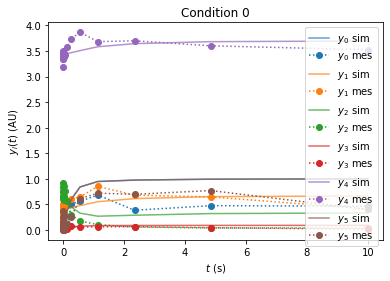

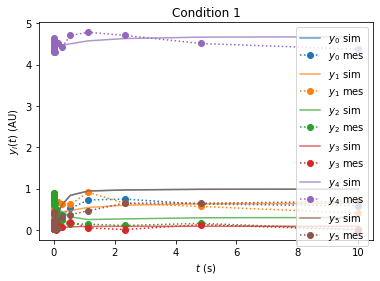

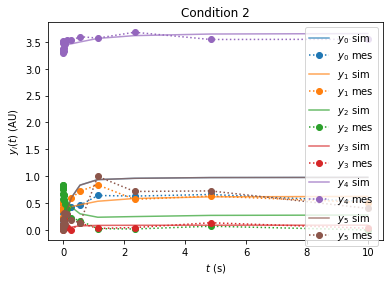

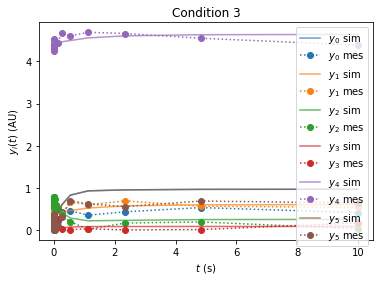

In [33]:
# Plot measurement trajectories (training data) and compare to model simulation with optimized parameters
parpe.plotting.plotTrajectoryFits(measured[start_idx], simulated[start_idx], timepoints[start_idx])

## Standard optimization vs. hierarchical optimization

In [34]:
# Accuracy of parameter estimates

start_idx = '0'
print('Hierarchical:')
parpe.compare_optimization_results_to_true_parameters(hdf5_pe_output_file_hierarchical, start_idx=start_idx)
print()
print('Standard:')
parpe.compare_optimization_results_to_true_parameters(hdf5_pe_output_file_standard, start_idx=start_idx)

Hierarchical:
#  __Exp____ __Act______ __Err______ __RelErr___ __ID_______
0:   1.00000     0.30545    -0.69455    -0.69455 p1
1:   0.50000     0.30115    -0.19885    -0.39771 p2
2:   0.40000     0.16319    -0.23681    -0.59202 p3
3:   2.00000     1.81038    -0.18962    -0.09481 p4
4:   0.10000     0.04623    -0.05377    -0.53775 p5
5:   2.00000     0.16235    -1.83765    -0.91882 scaling_x1_common
6:   3.00000     2.99965    -0.00035    -0.00012 offset_x2_batch_0
7:   0.20000     0.13704    -0.06296    -0.31482 x1withsigma_sigma
8:   4.00000     4.00120     0.00120     0.00030 offset_x2_batch_1

Status: 1
Cost: -447.236053 (expected: -0.000000)

Standard:
#  __Exp____ __Act______ __Err______ __RelErr___ __ID_______
0:   1.00000     0.27496    -0.72504    -0.72504 p1
1:   0.50000     0.30148    -0.19852    -0.39704 p2
2:   0.40000     0.14082    -0.25918    -0.64794 p3
3:   2.00000     1.80128    -0.19872    -0.09936 p4
4:   0.10000     0.04838    -0.05162    -0.51620 p5
5:   2.00000  

The previous block shows, that parameters are recovered more accurately by the hierarchical optimization approach.

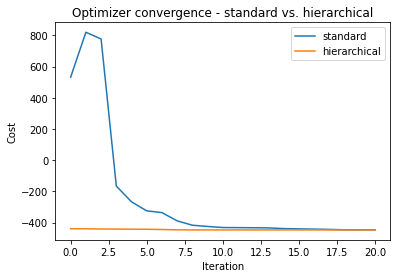

In [35]:
ax = parpe.plotting.plotCostTrajectory(trajectories_standard, log=False)
parpe.plotting.plotCostTrajectory(trajectories_hierarchical, log=False, ax=ax)
ax.autoscale(True)
ax.legend(['standard', 'hierarchical'])
ax.set_title('Optimizer convergence - standard vs. hierarchical');

Although it does not make a great difference for this tiny example, we can see, that the hierarchical approach convergences faster.

In [36]:
# Show best final objective for the two approaches (smaller means better):
print('Best objective standard:', np.min(trajectories_standard))
print('Best objective hierarchical:', np.min(trajectories_hierarchical))

Best objective standard: -446.9108155527413
Best objective hierarchical: -447.2360525867234
